## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "Weather in Szeged"
COLAB = 'google.colab' in sys.modules

DEBUG = False
SEED = 666

In [2]:
COLAB = 'google.colab' in sys.modules

if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
  if not os.path.isdir(ROOT): os.makedirs(ROOT)
else:
  ROOT = "./"

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

## Load Dataset

In [3]:
df = pd.read_pickle(f"{ROOT}/data/short_df.pickle")
df.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63
2,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41
4,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51


# Baseline Model

- Definição do Target = `'Temperature (C)'`

In [4]:
y = df['Temperature (C)']
y = y.values.ravel()

X = df.drop('Temperature (C)', axis=1)
X = X.drop('Apparent Temperature (C)', axis=1)

# Split

# Train/Test

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [7]:
classifiers = {
    "DTR" : DecisionTreeRegressor(),
    "DTR(max_depth=5)" : DecisionTreeRegressor(max_depth=5),
    "LR" : LinearRegression(),
    "SVR()" : SVR(),
    "SVR(kernel='linear')" : SVR(kernel='linear'),
}

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
scaler = StandardScaler()

for name, model in classifiers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    
    mse_train_cross_val_score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
    mse_train_cross_val_score = -mse_train_cross_val_score.mean()  # invertendo o sinal

    r2_train_cross_val_score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='r2')
    r2_train_cross_val_score = r2_train_cross_val_score.mean()

    print(f"{name:20s} mse_cross_val_score\ttrain = {mse_train_cross_val_score:.4f}\tr2_cross_val_score\ttrain = {r2_train_cross_val_score:.4f}")


DTR                  mse_cross_val_score	train = 8.3936	r2_cross_val_score	train = 0.5669
DTR(max_depth=5)     mse_cross_val_score	train = 6.9635	r2_cross_val_score	train = 0.6429
LR                   mse_cross_val_score	train = 6.2974	r2_cross_val_score	train = 0.6849
SVR()                mse_cross_val_score	train = 5.9109	r2_cross_val_score	train = 0.7027
SVR(kernel='linear') mse_cross_val_score	train = 6.3606	r2_cross_val_score	train = 0.6815


In [10]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  

DTR                  mse_score	train = 0.0000 	test = 11.2385
DTR                  r2_score	train = 1.0000 	test = 0.3717


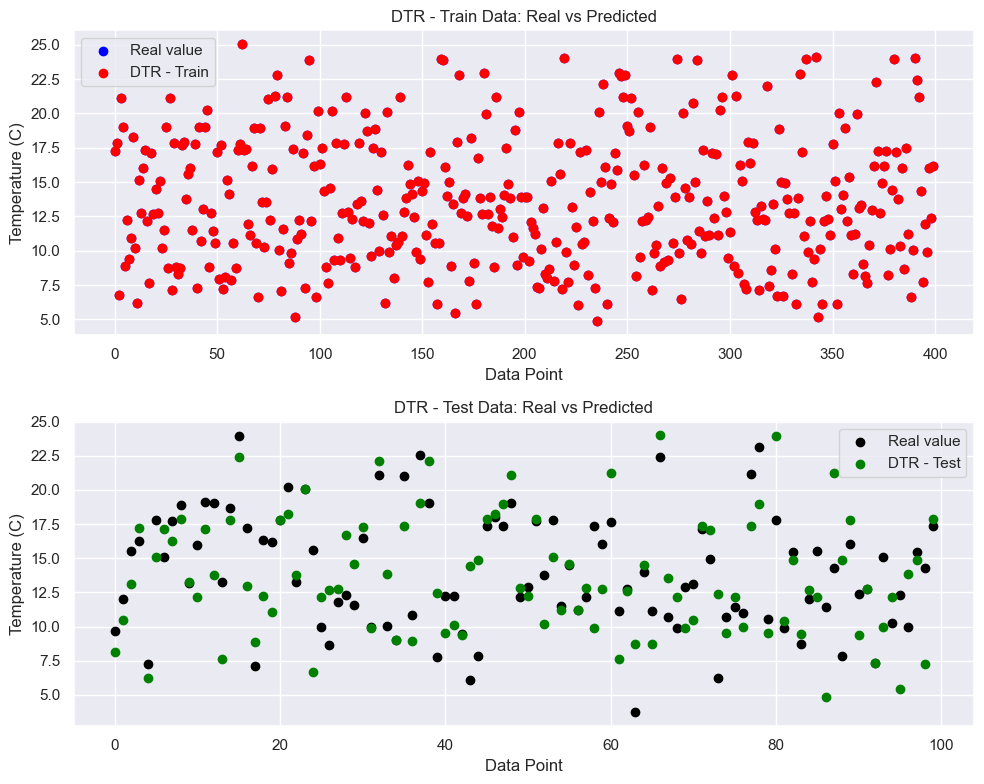

DTR(max_depth=5)     mse_score	train = 3.6090 	test = 9.4995
DTR(max_depth=5)     r2_score	train = 0.8315 	test = 0.4689


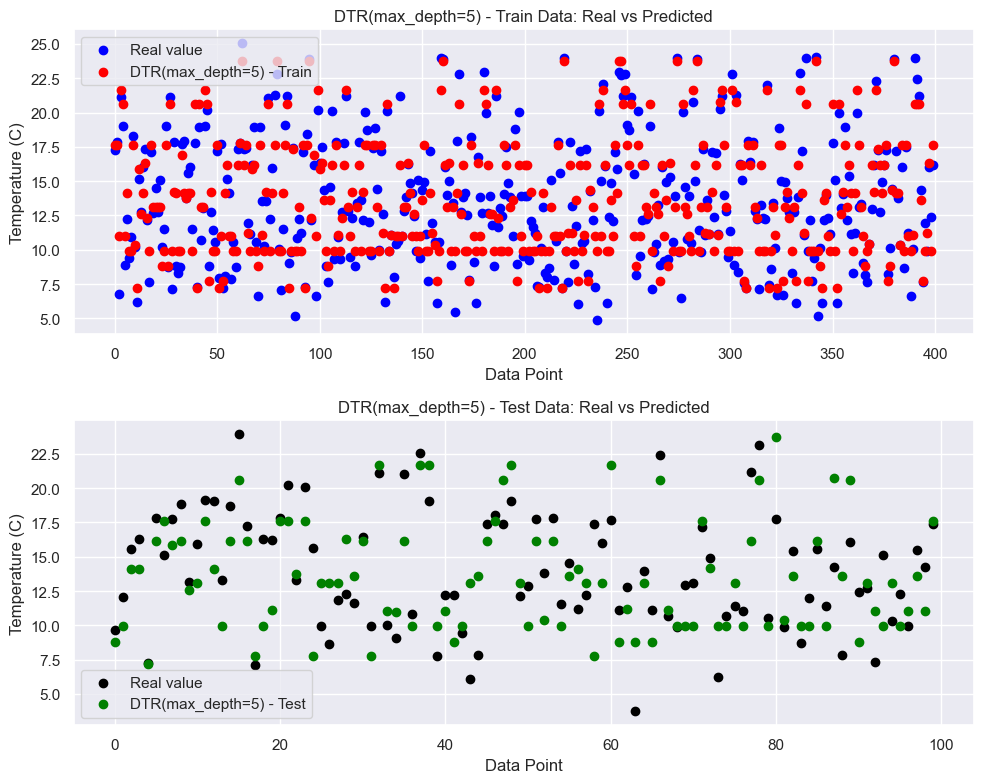

LR                   mse_score	train = 6.1087 	test = 7.0800
LR                   r2_score	train = 0.7148 	test = 0.6042


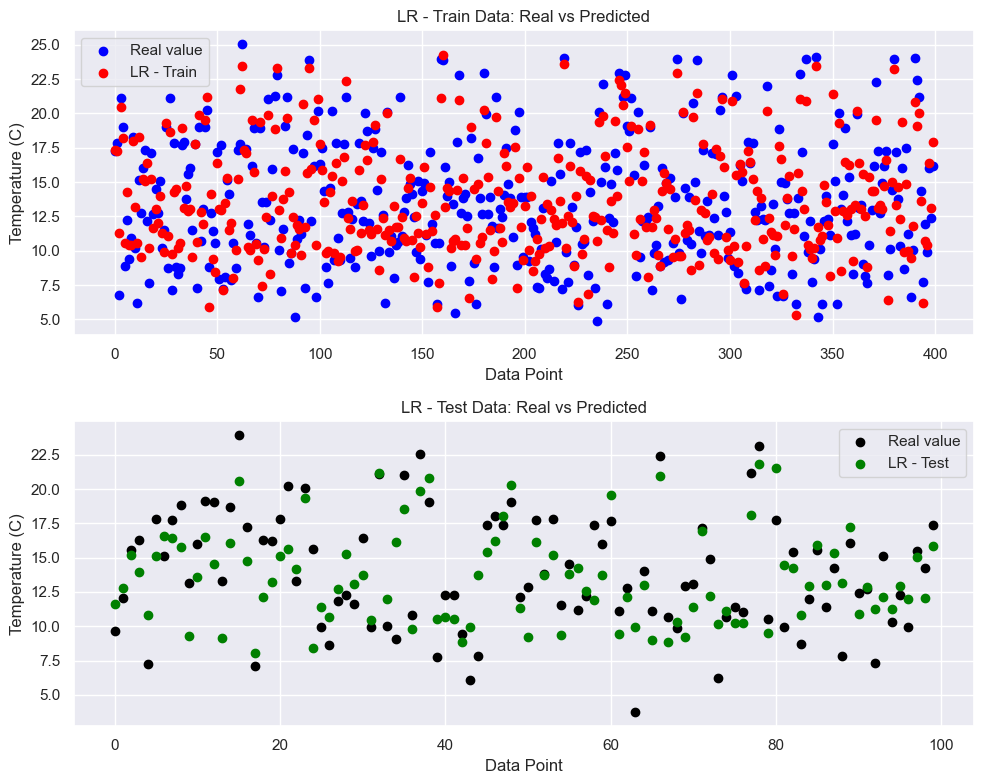

SVR()                mse_score	train = 5.0150 	test = 7.1429
SVR()                r2_score	train = 0.7659 	test = 0.6006


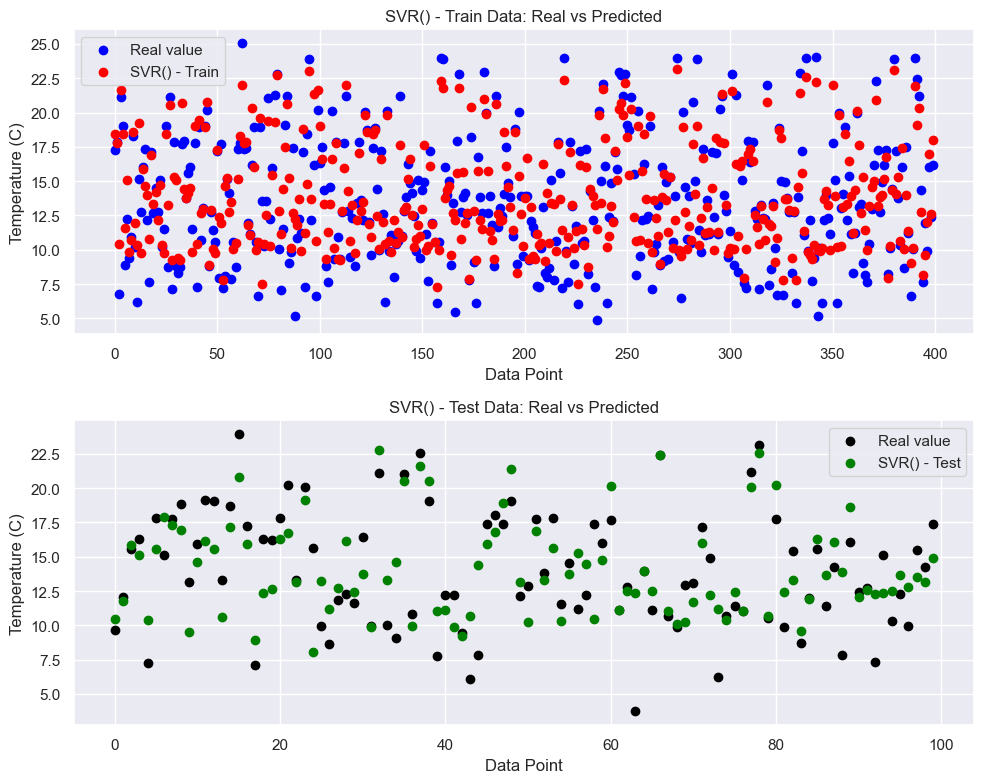

SVR(kernel='linear') mse_score	train = 6.2248 	test = 7.3170
SVR(kernel='linear') r2_score	train = 0.7094 	test = 0.5909


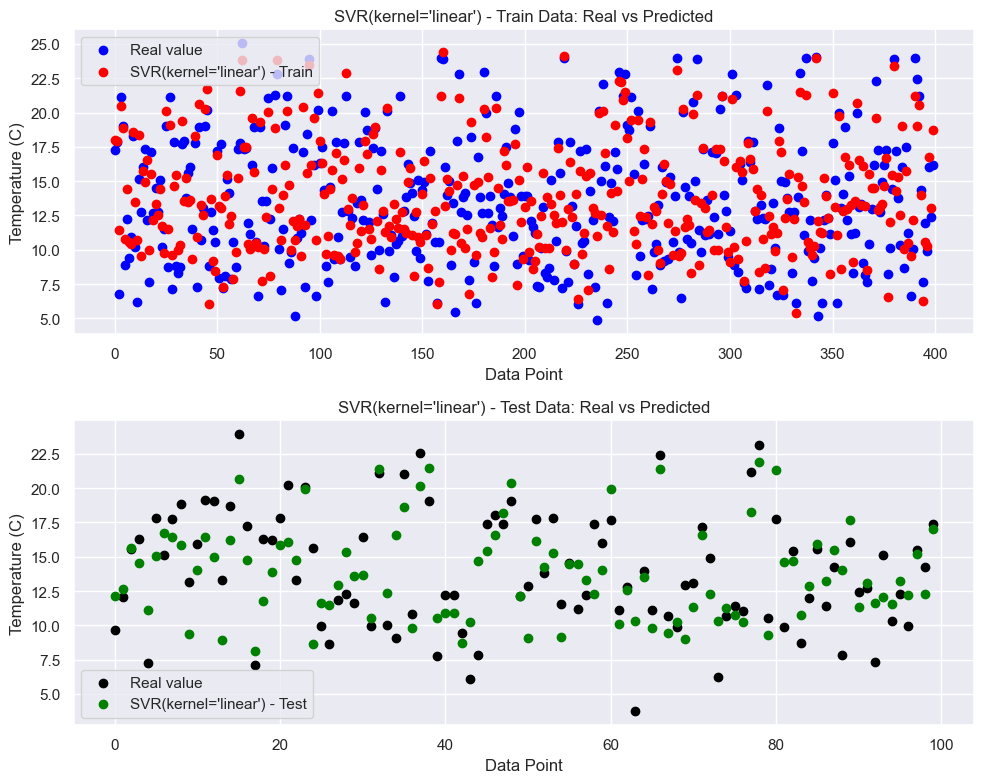

In [11]:
for name, model in classifiers.items():
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    train_r2_score = r2_score(y_train, y_pred_train)
    train_mse_score = mean_squared_error(y_train, y_pred_train)

    y_pred = model.predict(X_test)
    test_r2_score = r2_score(y_test, y_pred)
    test_mse_score = mean_squared_error(y_test, y_pred)
    
    print(f"{name:20s} mse_score\ttrain = {train_mse_score:.4f} \ttest = {test_mse_score:.4f}")
    print(f"{name:20s} r2_score\ttrain = {train_r2_score:.4f} \ttest = {test_r2_score:.4f}")

    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    x_train = np.arange(len(y_train))
    plt.scatter(x=x_train, y=y_train, color="blue", label="Real value")
    plt.scatter(x=x_train, y=y_pred_train, color="red", label=f"{name} - Train")
    plt.legend()
    plt.xlabel("Data Point")
    plt.ylabel("Temperature (C)")
    plt.title(f"{name} - Train Data: Real vs Predicted")

    plt.subplot(2, 1, 2)
    x_test = np.arange(len(y_test))
    plt.scatter(x=x_test, y=y_test, color="black", label="Real value")
    plt.scatter(x=x_test, y=y_pred, color="green", label=f"{name} - Test")
    plt.legend()
    plt.xlabel("Data Point")
    plt.ylabel("Temperature (C)")
    plt.title(f"{name} - Test Data: Real vs Predicted")

    plt.tight_layout()
    plt.show()

# Resultados

comente sobre os resultados

**DTR:** Sofreu overfitting. Ele ajusta-se perfeitamente aos dados de treino (R² = 1.0), mas tem desempenho ruim no teste, indicando que não generaliza bem.

**DTR(max_depth=5):** Limitar a profundidade melhora a generalização, mas ainda há uma diferença entre o treino e o teste, embora o overfitting seja menos severo.

**LR:** Tem um bom equilíbrio entre treino e teste, com bom desempenho em generalização.

**SVR():** Apresenta bom desempenho no treino, mas falha nos dados de teste, indicando possível overfitting.

**SVR(kernel='linear'):** É semelhante à LR, com desempenho razoável e melhor generalização que o SVR().

### O que é regressão em machine learning e qual é o seu principal objetivo?


A regressão em machine learning é uma técnica usada para modelar a relação entre uma variável dependente e uma ou mais variáveis independentes. Seu principal objetivo é prever valores contínuos e quantificar a relação entre as variáveis, como prever preços, temperaturas ou outras métricas numéricas.

### Uma vez definido o Target = 'Temperature (C)', por que é importante remover o `'Temperature (C)'` e `'Apparent Temperature (C)'` do `X` ? Se não fosse removido, isso impactaria na prática? Explique.

É importante remover **Temperature (C)** e **Apparent Temperature (C)** do conjunto de características **X** porque esses atributos são o alvo da previsão e não devem estar presentes nas características usadas para treinar o modelo. Se não fossem removidos, o modelo poderia "ver" o alvo diretamente e ajustar-se a ele de forma inadequada, resultando em uma avaliação enganosa da sua capacidade de generalização e desempenho. Isso levaria a um modelo que não é capaz de prever corretamente novos dados.

### Seria possível mudar o Target para 'Humidity'? Explique.

Sim, é possível mudar o alvo (target) para 'Humidity'. Isso envolveria ajustar o modelo para prever a umidade em vez da temperatura, utilizando a mesma abordagem de preparação dos dados e avaliação. Neste caso, teria que ajustar o código para que a variável dependente seja 'Humidity' e verificar se o modelo pode prever com precisão essa nova variável.